# ETL Project - First Delivery (1er Corte)

In [1]:
""" Creación de entorno virtual """
# python -m venv venv

""" Inicializar el entorno virtual """
# .\venv\Scripts\Activate

""" Actualizar la versión de pip """
# pip install --upgrade pip

""" Instalar requerimientos necesarios para ejecutar el ipynb sin problemas """
# pip install -r requirements.txt

' Instalar requerimientos necesarios para ejecutar el ipynb sin problemas '

In [2]:
import os
import psycopg2
from dotenv import load_dotenv

# Cargar variables
load_dotenv()

try:
    conn = psycopg2.connect(
        dbname=os.getenv("DB_NAME"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
        host=os.getenv("DB_HOST"),
        port=os.getenv("DB_PORT")
    )
    print("Successfully connected to PostgreSQL database.")
except psycopg2.Error as e:
    print(f"Error connecting to database: {e}")


Successfully connected to PostgreSQL database.


In [3]:
from sqlalchemy import create_engine
import pandas as pd
import os
from dotenv import load_dotenv

# Cargar variables
load_dotenv()

# Conexión a PostgreSQL
DB_URI = os.getenv("DB_URI")
engine = create_engine(DB_URI)

# 2. Cargar datos desde PostgreSQL
source_table = "spotify_most_streamed_2024"
df = pd.read_sql(f'SELECT * FROM {source_table}', engine)

print("Análisis inicial del DataFrame (desde BD):")
print(df.head())
print("\nInformación del DataFrame:")
print(df.info())
print("\nEstadísticas descriptivas:")
print(df.describe(include='all'))
print("\nConteo de valores nulos antes de la limpieza:")
print(df.isnull().sum())

print("\nColumnas disponibles en la tabla:")
print(df.columns.tolist())

# 3. Limpieza de datos
# Columnas que parecen numéricas según nombre
for col in df.columns:
    if any(keyword in col.lower() for keyword in ['stream','count','view','like','score','popularity','rank','spin','post']):
        try:
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
            print(f"Convertida columna numérica: {col}")
        except:
            print(f"No se pudo convertir {col} - manteniendo como texto")

# Columnas numéricas
date_keywords = ['date', 'release']
date_columns = [col for col in df.columns if any(k in col.lower() for k in date_keywords)]

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    print(f"Convertida columna de fecha: {col}")

# Limpiar separadores de miles si existieran
if 'All Time Rank' in df.columns:
    df['All Time Rank'] = pd.to_numeric(
        df['All Time Rank'].astype(str).str.replace(',', '', regex=False),
        errors='coerce'
    ).astype('Int64')
    print("All Time Rank convertido a Int64 (nullable integer).")

# Manejo de nulos
print("\nValores nulos antes del tratamiento:")
print(df.isnull().sum())

# Numéricas - rellenar con 0
numeric_cols = df.select_dtypes(include=['number']).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(0)

# Texto - rellenar con "Unknown"
text_cols = df.select_dtypes(include=['object']).columns
for col in text_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna("Unknown")

# Eliminar duplicados
df = df.drop_duplicates()

# 4. Verificación final
print("\nConteo de valores nulos después de la limpieza:")
print(df.isnull().sum())
print("\nInformación del DataFrame después de la limpieza:")
print(df.info())
print(f"\nTamaño final del DataFrame: {df.shape}")

# 5. Guardar datos limpios en BD
try:
    clean_table = "spotify_most_streamed_clean"
    df.to_sql(clean_table, engine, if_exists='replace', index=False)
    print(f"DataFrame limpio guardado en PostgreSQL como '{clean_table}' exitosamente!")
except Exception as e:
    print(f"Error al guardar en PostgreSQL: {e}")


Análisis inicial del DataFrame (desde BD):
                        Track                    Album Name          Artist  \
0         MILLION DOLLAR BABY  Million Dollar Baby - Single   Tommy Richman   
1                 Not Like Us                   Not Like Us  Kendrick Lamar   
2  i like the way you kiss me    I like the way you kiss me         Artemas   
3                     Flowers              Flowers - Single     Miley Cyrus   
4                     Houdini                       Houdini          Eminem   

  Release Date          ISRC  All Time Rank  Track Score  Spotify Streams  \
0   2024-04-26  QM24S2402528              1        725.4            390.0   
1   2024-05-04  USUG12400910              2        545.9            323.0   
2   2024-03-19  QZJ842400387              3        538.4            601.0   
3   2023-01-12  USSM12209777              4        444.9              2.0   
4   2024-05-31  USUG12403398              5        423.3            107.0   

   Spotify Playlist

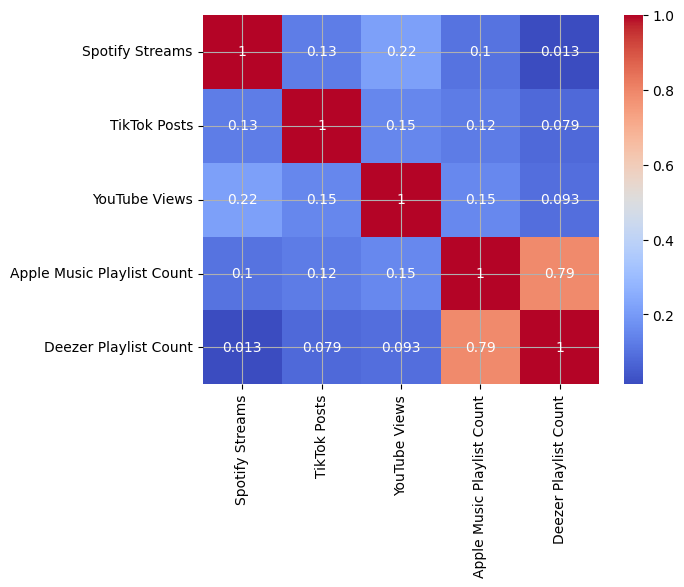

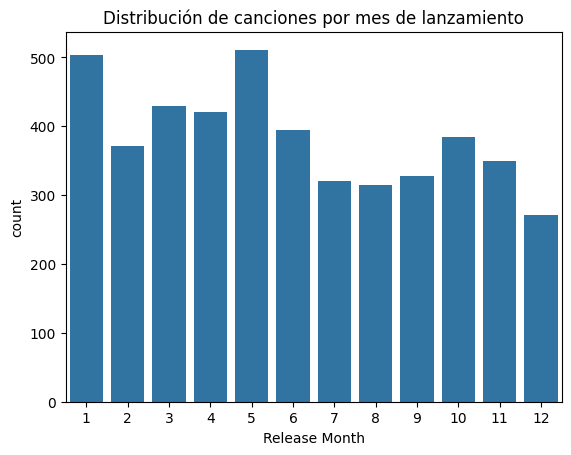

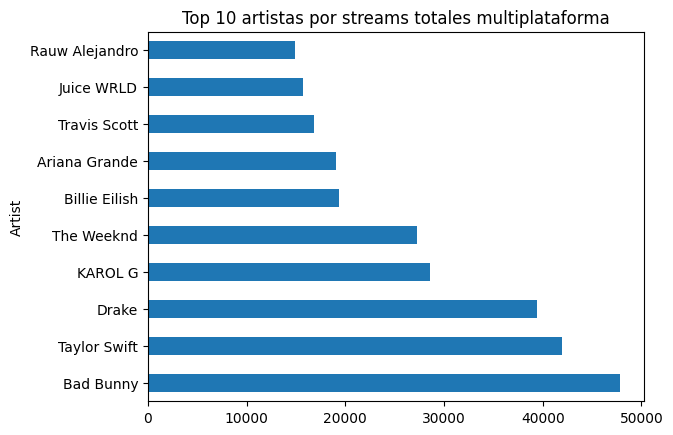

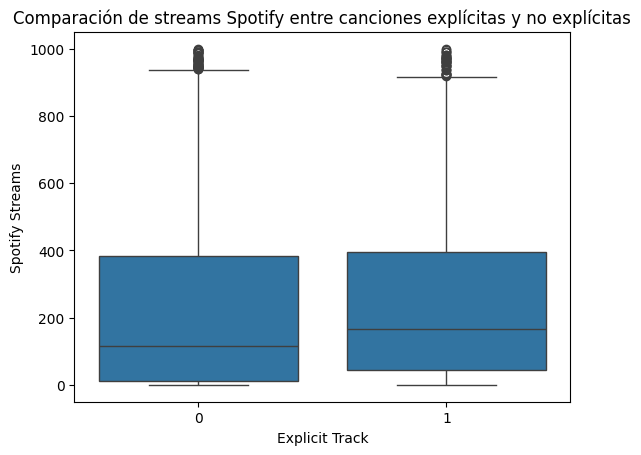

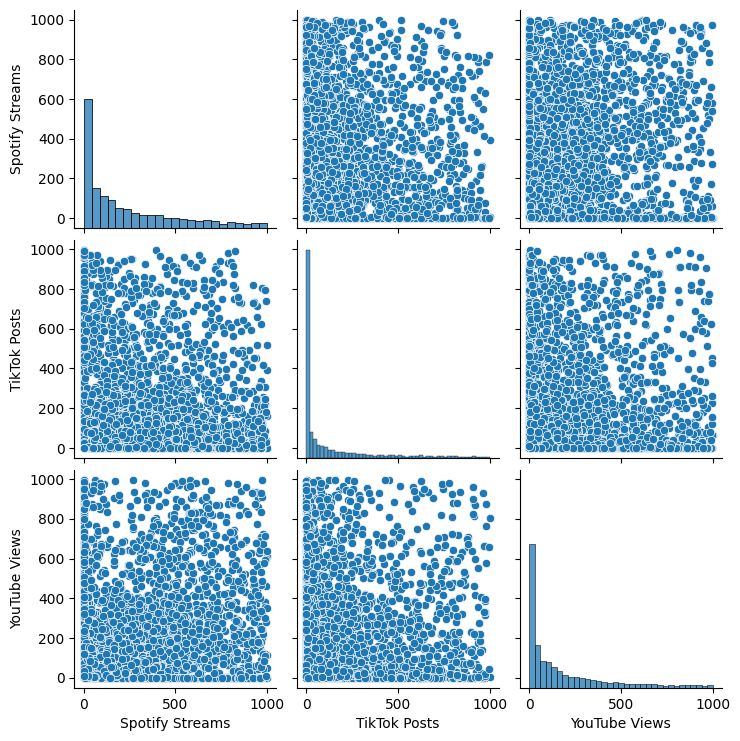

In [4]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sqlalchemy import create_engine
from dotenv import load_dotenv

# Cargar variables
load_dotenv()

# Conexión a PostgreSQL
DB_URI = os.getenv("DB_URI")
engine = create_engine(DB_URI)

# Leer datos limpios
df = pd.read_sql("SELECT * FROM spotify_most_streamed_clean", engine)
df.head()

""" Análisis exploratorio de datos (EDA) """
# a) Estadísticas generales
# Número de canciones por artista
df['Artist'].value_counts().head(10)

# Distribución de streams en Spotify
df['Spotify Streams'].hist(bins=50)

# Conteo de canciones explícitas
df['Explicit Track'].value_counts()

#b) Correlaciones entre plataformas
# Correlación entre algunas métricas clave
cols = ['Spotify Streams', 'TikTok Posts', 'YouTube Views', 'Apple Music Playlist Count', 'Deezer Playlist Count']
sns.heatmap(df[cols].corr(), annot=True, cmap="coolwarm")
plt.show()

# c) Tendencias temporales
df['Release Month'] = df['Release Date'].dt.month
sns.countplot(x='Release Month', data=df)
plt.title("Distribución de canciones por mes de lanzamiento")
plt.show()

# d) Identificación de artistas multiplataforma
df['Total Streams'] = df['Spotify Streams'] + df['YouTube Views'] + df['TikTok Views']
top_artists = df.groupby('Artist')['Total Streams'].sum().sort_values(ascending=False).head(10)
top_artists.plot(kind='barh')
plt.title("Top 10 artistas por streams totales multiplataforma")
plt.show()

# e) Comparación explícitas vs no explícitas
sns.boxplot(x='Explicit Track', y='Spotify Streams', data=df)
plt.title("Comparación de streams Spotify entre canciones explícitas y no explícitas")
plt.show()

# f) Visualizaciones multicanal
sns.pairplot(df[['Spotify Streams', 'TikTok Posts', 'YouTube Views']])
plt.show()


# **Conclusiones**
# Correlación entre plataformas

El **heatmap** (mapa de calor) nos ayuda a ver cómo se relacionan las métricas entre distintas plataformas.

### ¿Existe una correlación entre el número de posts en TikTok y los streams en Spotify?
Sí. La correlación entre **Spotify Streams** y **TikTok Posts** es de **0.13**.  
No es una correlación fuerte, pero sí positiva: a medida que aumentan los posts en TikTok, también tienden a subir las reproducciones en Spotify. Esto sugiere que TikTok funciona como un empujón para el éxito en otras plataformas.

### ¿Las canciones que aparecen en muchas playlists de Spotify también tienen alcance en Deezer o Apple Music?
Totalmente. La correlación entre **Apple Music Playlist Count** y **Deezer Playlist Count** es de **0.79**, lo cual es bastante alto. Esto muestra que cuando una canción entra con fuerza en las playlists de una plataforma de audio, suele replicar su éxito en otras. Hay, por tanto, una consistencia clara en cómo se comporta la popularidad de un tema entre distintos servicios de streaming.

---

# Distribución y desempeño de las canciones

Con el gráfico de barras y el boxplot podemos ver cómo se distribuyen los lanzamientos en el año y cómo rinden en Spotify.

### ¿Cómo se distribuyen las canciones por mes de lanzamiento? ¿Existen temporadas de éxito?
Sí. El **countplot** revela que hay meses con más actividad que otros: **enero** y **mayo** destacan como los de mayor cantidad de lanzamientos. En cambio, los meses de verano (**julio y agosto**) y **diciembre** tienen menos estrenos. Esto podría indicar que hay estrategias de temporada detrás de las fechas de lanzamiento.

### ¿Las canciones explícitas tienen mejor desempeño en ciertas plataformas?
El **boxplot** que compara streams de canciones explícitas vs. no explícitas en Spotify muestra que la **mediana de reproducciones** es similar en ambos casos.  
Sin embargo, las canciones explícitas presentan un **rango intercuartílico más amplio** y más **outliers con streams muy altos**. Es decir: aunque en promedio no hay grandes diferencias, las canciones explícitas tienen más probabilidades de pegar un gran golpe de éxito.

---

# Presencia multiplataforma

El gráfico de barras horizontales resume el rendimiento de los artistas en varias plataformas al mismo tiempo.

### ¿Qué artistas tienen mayor presencia multiplataforma?
El gráfico de **“Top 10 artistas por streams totales multiplataforma”** deja claro que **Bad Bunny** encabeza la lista con la mayor cantidad de streams combinados.  
Le siguen **Taylor Swift** y **Drake**, consolidándose como los artistas con más alcance general en todas las plataformas analizadas.

